In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
WORK_DIR = '/content/drive/My Drive/FINA4350'
DATA_DIR = f'{WORK_DIR}/datasets/cashcowputer-dataset'

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


## Libraries and General functions

In [0]:
import numpy as np
import pandas as pd

In [0]:
import datetime
combined_data = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets.csv')
all_stock_price = pd.read_csv(f'{DATA_DIR}/preprocessed/price/all_stock_price.csv')
price_days = list(combined_data['timestamp'].unique()) 
work_days = list(all_stock_price['timestamp'].unique())
end = pd.to_datetime('2016-04-01')
next_work_day_map = dict()
for i in range(len(price_days)):
  date = price_days[i]
  next_work_day = pd.to_datetime(date) + datetime.timedelta(days=1)
  #print(next_work_day)
  decay = 0
  while next_work_day.strftime('%Y-%m-%d') not in work_days or next_work_day.strftime('%Y-%m-%d') not in price_days:
      if(next_work_day > end): break
      next_work_day += datetime.timedelta(days=1)
      decay += 1
  next_work_day_map[str(date)] = next_work_day.strftime('%Y-%m-%d')
stock_return_map = dict()
for i,row in combined_data.iterrows():
  stock_return_map[(str(row['timestamp']),row['asset'])] = row['return']

In [180]:
assert(stock_return_map[('2014-01-09','VZ')]==-0.020618556701030966)

AssertionError: ignored

In [0]:
assert(next_work_day_map['2014-01-16']=='2014-01-21')

In [0]:
def next_n_working_day(date,n):
  cur = date
  while n > 0:
    next_work_day = next_work_day_map[cur]
    cur = next_work_day
    if cur not in price_days:
      return cur
    n-=1
  return cur
def generate_day_n_dataset(n):
  temp = []
  for stock, df in combined_data.groupby(combined_data.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      sentiment = row['sentiment']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment'])

## Dataset Indexing

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub

In [126]:
import json
with open(f'{WORK_DIR}/models/new-2-DNN-keras_args.json') as f:
  args = json.load(f)
args

{'activation': 'relu',
 'batch_size': 256,
 'embed_size': 512,
 'epochs': 20,
 'loss': 'binary_crossentropy',
 'model_name': 'new-2-DNN-keras',
 'numberOfOutputClasses': 1,
 'optimizer': 'adam',
 'output_acitivation': 'sigmoid'}

In [0]:
module_path = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
embed = hub.load(module_path)
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']

In [0]:
def create_model():
  input_text = layers.Input(shape=(1,), dtype=tf.string)
  embedding = layers.Lambda(UniversalEmbedding, output_shape=(args['embed_size'],))(input_text)
  dropout = layers.Dropout(0.1)(embedding)
  dense = layers.Dense(256, activation=args['activation'])(dropout)
  dropout1 = layers.Dropout(0.1)(dense)
  pred = layers.Dense(args['numberOfOutputClasses'], args['output_acitivation'])(dropout1)
  model = Model(inputs=[input_text], outputs=pred)
  model.compile(loss=args['loss'], optimizer=args['optimizer'], metrics=['accuracy'])
  return model

In [0]:
WEIGHTS_PATH = f'{WORK_DIR}/models/new-2-DNN-keras.h5'
model = create_model()
model.load_weights(WEIGHTS_PATH)

In [0]:
import numpy as np
import pandas as pd

In [0]:
x_test = np.asarray(
    ['I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I hate you'])
x_test

array(['I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I hate you'],
      dtype='<U538')

In [0]:
all_stock_tweets = pd.read_csv(f'{DATA_DIR}/preprocessed/tweets/all_indexed_stock_tweets.csv')

In [0]:
all_stock_tweets.head()

,timestamp,source,asset,cleaned_text
0,2014-01-03,tweet,VZ,weekly dow hashtag stocks hashtag trend dis wm...
1,2014-01-03,tweet,VZ,vz a new year means time for new dogs of the d...
2,2014-01-05,tweet,VZ,vz the s ps worst sectors in number url
3,2014-01-09,tweet,VZ,vz why t mobile bought verizons spectrum url
4,2014-01-10,tweet,VZ,hashtag video hashtag hashtag accumulation dis...


In [0]:
x = all_stock_tweets.cleaned_text.values

In [0]:
preds = model.predict(x)

In [0]:
all_stock_tweets['sentiment'] = preds

In [0]:
all_stock_tweets.tail()

,timestamp,source,asset,cleaned_text,sentiment
105556,2015-10-06,tweet,CODI,codi received a new alert find out why at url,0.454480
105557,2015-10-07,tweet,CODI,codi is rated buy percent upside by wall stree...,0.492932
105558,2015-11-11,tweet,CODI,compass diversified holdings stock rating reaf...,0.712209
105559,2015-11-13,tweet,CODI,codi compass diversified holdings nyse codi st...,0.286823
105560,2016-01-20,tweet,CODI,this stock has a percent yield and sells for l...,0.563455


In [0]:
x_test = ['I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy hate rubbish rubbish','hi']
x_test =np.asarray(x_test,dtype='object')
x_test

array(['I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy I am happy hate rubbish rubbish',
       'hi'], dtype=object)

In [0]:
model.predict(x_test)

array([[0.94497925],
       [0.6760514 ]], dtype=float32)

In [0]:
all_stock_tweets.to_csv(f'{DATA_DIR}/indexed/tweets/new_indexed_tweets.csv',index=False)

In [0]:
news = pd.read_csv(f'{DATA_DIR}/preprocessed/news/news.csv')

In [0]:
news['combined_title_content'] = news[['title','content']].apply(lambda x:' '.join(x.dropna()), axis=1)

In [0]:
news.drop_duplicates(keep='first',inplace=True)

In [0]:
news.head()

,timestamp,title,content,source,combined_title_content
0,2014-01-01,business insider,back in clement c moore published the classic ...,news_full,business insider back in clement c moore publi...
1,2014-01-01,business insider,how much do million turkeys weigh that is the ...,news_full,business insider how much do million turkeys w...
2,2014-01-01,business insider,it is thanksgiving week once again and here at...,news_full,business insider it is thanksgiving week once ...
3,2014-01-01,business insider,if you take time to think about it the sun is ...,news_full,business insider if you take time to think abo...
4,2014-01-01,business insider,now that it is the day after thanksgiving when...,news_full,business insider now that it is the day after ...


In [0]:
x = news.combined_title_content.values

In [0]:
x[:1]

array(['business insider back in clement c moore published the classic christmas poem twas the night before christmas which convinced the world once and for all time that saint nicholas perhaps now better known as santa claus traveled the world in a miniature sleigh pulled by eight tiny reindeer did you ever wonder what that sleigh looked like to find out what a sleigh in clement moores time might have looked like we turned to the you s patent office since many inventions like sleighs really represent the results of the cumulative incremental improvements of things that already exist by going to the earliest sleighrelated patents we should be able to get a good sense of what they looked like in that early era the oldest patent for a sleigh in the united states that we could find is represented in you s patent which was issued to daniel carpenter of nelson new york on september as you can see it is really more of a sled but it really gives a good idea of what the suspension for a sleigh

In [0]:
preds = model.predict(x, batch_size=2)

ResourceExhaustedError: ignored

In [0]:
from tensorflow.keras.models import model_from_json
import json
with open(f'{WORK_DIR}/models/DAN-2-DNN-keras.json') as f:
  json_model = json.load(f)

In [124]:
module_path = 'https://tfhub.dev/google/universal-sentence-encoder/3'
embed = hub.load(module_path)
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']

NameError: ignored

In [0]:
model_for_news = model_from_json(json_model)

In [0]:
preds = model_for_news.predict(x)

In [0]:
news['sentiment'] = preds

In [0]:
news.head()

,timestamp,title,content,source,combined_title_content,sentiment
0,2014-01-01,business insider,back in clement c moore published the classic ...,news_full,business insider back in clement c moore publi...,0.481818
1,2014-01-01,business insider,how much do million turkeys weigh that is the ...,news_full,business insider how much do million turkeys w...,0.488750
2,2014-01-01,business insider,it is thanksgiving week once again and here at...,news_full,business insider it is thanksgiving week once ...,0.484320
3,2014-01-01,business insider,if you take time to think about it the sun is ...,news_full,business insider if you take time to think abo...,0.480509
4,2014-01-01,business insider,now that it is the day after thanksgiving when...,news_full,business insider now that it is the day after ...,0.488783


In [0]:
news.sentiment.mean()

0.4763179123401642

In [0]:
news[['timestamp','combined_title_content','sentiment']].to_csv(f'{DATA_DIR}/indexed/news/new_indexed_tweets.csv',index=False)

In [132]:
news_title_only = news[news['source']!='news_full']
news_title_values = news_title_only.title.values
news_title_values.shape

(22808,)

In [0]:
preds = model.predict(news_title_values)

In [134]:
news_title_only['sentiment'] = preds
news_title_only.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timestamp,title,content,source,sentiment
5,2014-01-01,the daily dot the nsa leaks you need to unders...,NaN,news_title_only,0.824581
7,2014-01-01,hadron collider upgrade will lead to highest e...,NaN,news_title_only,0.818177
15,2014-01-01,egypt says journalists will be held more days,NaN,news_title_only,0.260239
16,2014-01-01,latvia becomes th eurozone member,NaN,news_title_only,0.783358
19,2014-01-01,most australians want google to stop giving da...,NaN,news_title_only,0.457299


In [0]:
news_title_only[['timestamp','title','sentiment']].to_csv(f'{DATA_DIR}/indexed/news/indexed_news_title_only_.csv',index=False)

In [0]:
import pandas as pd

In [0]:
indexed_tweets = pd.read_csv(f'{DATA_DIR}/indexed/tweets/new_indexed_tweets.csv')

In [0]:
indexed_news = pd.read_csv(f'{DATA_DIR}/indexed/news/new_indexed_news.csv')

In [0]:
all_stock_price = pd.read_csv(f'{DATA_DIR}/preprocessed/price/all_stock_price.csv')

In [0]:
indexed_tweets.head()

,timestamp,source,asset,cleaned_text,sentiment
0,2014-01-03,tweet,VZ,weekly dow hashtag stocks hashtag trend dis wm...,0.756567
1,2014-01-03,tweet,VZ,vz a new year means time for new dogs of the d...,0.960307
2,2014-01-05,tweet,VZ,vz the s ps worst sectors in number url,0.144544
3,2014-01-09,tweet,VZ,vz why t mobile bought verizons spectrum url,0.076772
4,2014-01-10,tweet,VZ,hashtag video hashtag hashtag accumulation dis...,0.648278


In [0]:
work_days = list(all_stock_price['timestamp'].unique())
len(work_days)

756

In [0]:
tweets_days = list(indexed_tweets['timestamp'].unique())
len(tweets_days)

786

In [0]:
news_days = list(indexed_news['timestamp'].unique())
len(news_days)

1096

In [0]:
import datetime
next_work_day_map = dict()
for date in tweets_days:
    next_work_day = pd.to_datetime(date)
    decay = 0
    while next_work_day.strftime('%Y-%m-%d') not in work_days:
        next_work_day += datetime.timedelta(days=1)
        decay += 1
    next_work_day_map[date] = (next_work_day.strftime('%Y-%m-%d'),decay)

In [0]:
indexed_tweets.loc[:,'next_work_day'] = indexed_tweets['timestamp'].apply(lambda x: next_work_day_map[x][0])
indexed_tweets.loc[:,'decay'] = indexed_tweets['timestamp'].apply(lambda x: next_work_day_map[x][1])

In [0]:
indexed_tweets.head()

,timestamp,source,asset,cleaned_text,sentiment,next_work_day,decay
0,2014-01-03,tweet,VZ,weekly dow hashtag stocks hashtag trend dis wm...,0.756567,2014-01-03,0
1,2014-01-03,tweet,VZ,vz a new year means time for new dogs of the d...,0.960307,2014-01-03,0
2,2014-01-05,tweet,VZ,vz the s ps worst sectors in number url,0.144544,2014-01-06,1
3,2014-01-09,tweet,VZ,vz why t mobile bought verizons spectrum url,0.076772,2014-01-09,0
4,2014-01-10,tweet,VZ,hashtag video hashtag hashtag accumulation dis...,0.648278,2014-01-10,0


In [0]:
indexed_tweets_by_day = indexed_tweets.groupby(indexed_tweets.timestamp)

In [0]:
indexed_tweets_by_stock = indexed_tweets.groupby(indexed_tweets.asset)

In [0]:
temp = []
for stock_name,v in indexed_tweets_by_stock:
    stock_by_day = v.groupby(v.timestamp)
    for group_name,group_values in stock_by_day:
      avg_sentiment = group_values['sentiment'].mean()
      next_work_day = next_work_day_map[group_name][0]
      decay = next_work_day_map[group_name][1]
      asset = stock_name
      temp.append([group_name,asset,avg_sentiment,next_work_day,decay])
average_indexed_tweets = pd.DataFrame(np.array(temp),columns=['timestamp','asset','sentiment','next_work_day','decay'])

In [0]:
average_indexed_tweets.tail()

,timestamp,asset,sentiment,next_work_day,decay
29245,2016-03-25,XOM,0.56379793,2016-03-28,3
29246,2016-03-28,XOM,0.6580716999999999,2016-03-28,0
29247,2016-03-29,XOM,0.42856015500000005,2016-03-29,0
29248,2016-03-30,XOM,0.6625677320000001,2016-03-30,0
29249,2016-03-31,XOM,0.52135225,2016-03-31,0


### Weighted average decay

In [0]:
temp = []
decayed_sen = []
for i,row in average_indexed_tweets.iterrows():
    decayed_sen.append(float(row['sentiment']))
    if int(row['decay']) == 0:
        sentiment = 0
        total_weight = 0
        for i in range(len(decayed_sen)):
          weight = pow((1/2),i)
          total_weight += weight
          sentiment += weight*decayed_sen[i]
        sentiment /= total_weight
        temp.append([row['timestamp'],sentiment])
decayed_stock_tweets = pd.DataFrame(temp, columns=['timestamp','sentiment'])

In [0]:
average_indexed_tweets_by_stock = average_indexed_tweets.groupby(average_indexed_tweets.asset)

In [0]:
temp = []
for stock_name,v in average_indexed_tweets_by_stock:
  decayed_sen = []
  for i,row in v.iterrows():
    decayed_sen.append(float(row['sentiment']))
    if int(row['decay']) == 0:
        sentiment = 0
        total_weight = 0
        for i in range(len(decayed_sen)):
          weight = pow((1/2),i)
          total_weight += weight
          sentiment += weight*decayed_sen[i]
        sentiment /= total_weight
        temp.append([row['timestamp'],stock_name,sentiment])
        decayed_sen = []
decayed_stock_tweets = pd.DataFrame(temp, columns=['timestamp','asset','sentiment'])

In [0]:
decayed_stock_tweets.tail()

,timestamp,asset,sentiment
22017,2016-03-24,XOM,0.540336
22018,2016-03-28,XOM,0.595223
22019,2016-03-29,XOM,0.428560
22020,2016-03-30,XOM,0.662568
22021,2016-03-31,XOM,0.521352


In [0]:
print(len(decayed_stock_tweets.timestamp.unique()))

540


In [0]:
decayed_stock_tweets.to_csv(f'{DATA_DIR}/analysis/weighted_decayed_tweet_sentiment.csv',index=False)

In [26]:
all_stock_price.head()

,timestamp,asset,Open,Close,Volume
0,2014-01-02,VZ,49.080002,49.000000,9270200.0
1,2014-01-03,VZ,49.330002,48.419998,12022200.0
2,2014-01-06,VZ,48.770000,48.689999,16054800.0
3,2014-01-07,VZ,49.119999,49.299999,17594600.0
4,2014-01-08,VZ,48.689999,48.500000,13110700.0


In [27]:
data = []
all_stock_price_by_stock = all_stock_price.groupby(all_stock_price.asset)
for stock, df in all_stock_price_by_stock :
  df.loc[:,'return'] = df['Close'].pct_change()
  data.append(df.values.tolist())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item)

In [0]:
import numpy as np
all_stock_price_change = pd.DataFrame(np.asarray(flat_list),columns=['timestamp','asset','Open','Close','Volume','return'])

In [31]:
all_stock_price_change.head()

,timestamp,asset,Open,Close,Volume,return
0,2014-01-02,AAPL,79.382858,79.01857,58671200.0,nan
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021965849293400286
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453020242780937
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007151600455496232
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.00633285838396902


In [0]:
decayed_stock_tweets = pd.read_csv(f'{DATA_DIR}/analysis/weighted_decayed_tweet_sentiment.csv')

In [34]:
combined_data = all_stock_price_change.merge(decayed_stock_tweets, on=['timestamp','asset'])
combined_data.head()

,timestamp,asset,Open,Close,Volume,return,sentiment
0,2014-01-02,AAPL,79.382858,79.01857,58671200.0,nan,0.565564
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021965849293400286,0.601761
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453020242780937,0.691132
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007151600455496232,0.669051
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.00633285838396902,0.691764


In [0]:
combined_data.to_csv(f'{DATA_DIR}/analysis/combined_price_tweets.csv',index=False)

In [0]:
import pandas as pd
combined_data = pd.read_csv(f'{DATA_DIR}/analysis/day_0.csv')

In [0]:
combined_data.head()

,timestamp,asset,Open,Close,Volume,return,sentiment
0,2014-01-03,VZ,49.330002,48.419998,12022200.0,-0.011837,0.858437
1,2014-01-09,VZ,48.430000,47.500000,14567000.0,-0.020619,0.121953
2,2014-01-10,VZ,47.840000,47.750000,11445900.0,0.005263,0.493868
3,2014-01-13,VZ,47.650002,47.029999,18784000.0,-0.015079,0.566625
4,2014-01-14,VZ,47.040001,47.080002,19270700.0,0.001063,0.028749


In [0]:
combined_data['return']= combined_data['return'].apply(lambda x:float(x))

## Section 1: Stock return v Abs. Sentiment score of Tweets

### Day-0 test (extra)

In [0]:
combined_data_day_0 = combined_data.dropna(axis=0)

In [57]:
combined_data_day_0.head()

,timestamp,asset,Open,Close,Volume,return,sentiment
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021966,0.601761
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453,0.691132
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007152,0.669051
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.006333,0.691764
5,2014-01-09,AAPL,78.114288,76.645714,69787200.0,-0.012770,0.512157


In [0]:
returns = combined_data_day_0['return'].values
sentiments = combined_data_day_0['sentiment'].values

In [59]:
returns.shape,sentiments.shape

((21953,), (21953,))

In [0]:
sentiments = sentiments.reshape(-1, 1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [62]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)

In [64]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.3964323679509809
-0.395603085931872
0.00033775682560039847


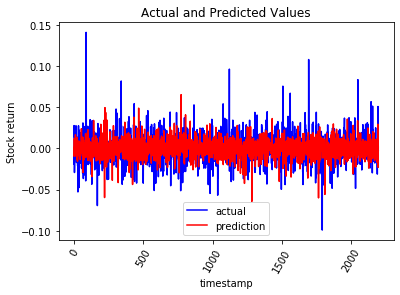

In [66]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [67]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_test, y_test)

-0.0009239542340739871

### Day-1 Test

In [0]:
import datetime
price_days = list(combined_data['timestamp'].unique()) 
work_days = list(all_stock_price['timestamp'].unique())
end = pd.to_datetime('2016-04-01')
next_work_day_map = dict()
for i in range(len(price_days)):
  date = price_days[i]
  next_work_day = pd.to_datetime(date) + datetime.timedelta(days=1)
  #print(next_work_day)
  decay = 0
  while next_work_day.strftime('%Y-%m-%d') not in work_days or next_work_day.strftime('%Y-%m-%d') not in price_days:
      if(next_work_day > end): break
      next_work_day += datetime.timedelta(days=1)
      decay += 1
  next_work_day_map[str(date)] = next_work_day.strftime('%Y-%m-%d')
stock_return_map = dict()
for i,row in combined_data.iterrows():
  stock_return_map[(str(row['timestamp']),row['asset'])] = row['return']

In [0]:
assert(stock_return_map[('2014-01-09','VZ')]==-0.020618556701030966)

In [0]:
assert(next_work_day_map['2014-01-16']=='2014-01-21')

In [0]:
def next_n_working_day(date,n):
  cur = date
  while n > 0:
    next_work_day = next_work_day_map[cur]
    cur = next_work_day
    if cur not in price_days:
      return cur
    n-=1
  return cur
def generate_day_n_dataset(n):
  temp = []
  for stock, df in combined_data.groupby(combined_data.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      sentiment = row['sentiment']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment'])

In [0]:
combined_data_day_1 = generate_day_n_dataset(1)

In [0]:
combined_data_day_1.dropna(axis=0,inplace=True)

In [151]:
combined_data_day_1.shape

(15569, 4)

In [75]:
combined_data_day_1.head()

,timestamp,return,asset,sentiment
0,2014-01-02,-0.021966,AAPL,0.565564
1,2014-01-03,0.005453,AAPL,0.601761
2,2014-01-06,-0.007152,AAPL,0.691132
3,2014-01-07,0.006333,AAPL,0.669051
4,2014-01-08,-0.012770,AAPL,0.691764


In [0]:
combined_data_day_1.head()

,timestamp,return,asset,sentiment
0,2014-01-02,-0.021966,AAPL,0.565564
1,2014-01-03,0.005453,AAPL,0.601761
2,2014-01-06,-0.007152,AAPL,0.691132
3,2014-01-07,0.006333,AAPL,0.669051
4,2014-01-08,-0.012770,AAPL,0.691764


In [0]:
combined_data_day_1.dropna(axis=0,inplace=True)

#### Percentage change

In [0]:
returns = combined_data_day_1['return'].values
sentiments = combined_data_day_1['sentiment'].values.reshape(-1,1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [80]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.4549996523471025
-0.4536163558094717
0.0003353674211696234


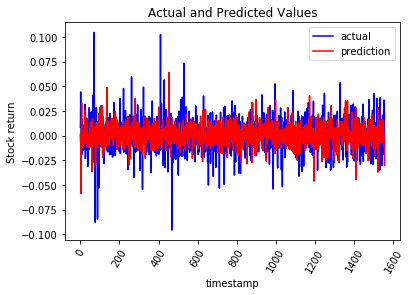

In [81]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

In [179]:
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.00017126256350175062
0.0002071178536473539
0.00022556408284618367


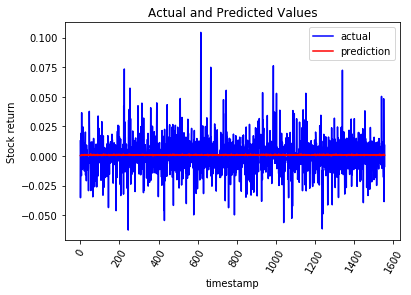

In [180]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

#### Directionality

In [0]:
combined_data_day_1['direction'] = combined_data_day_1['return'].apply(lambda x: 0 if x<0 else 1) #0=down 1=up

In [153]:
combined_data_day_1.head()

,timestamp,return,asset,sentiment,direction
0,2014-01-02,-0.021966,AAPL,0.565564,0
1,2014-01-03,0.005453,AAPL,0.601761,1
2,2014-01-06,-0.007152,AAPL,0.691132,0
3,2014-01-07,0.006333,AAPL,0.669051,1
4,2014-01-08,-0.012770,AAPL,0.691764,0


In [0]:
directions = combined_data_day_1['direction'].values
sentiments = combined_data_day_1['sentiment'].values.reshape(-1,1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(sentiments, directions, test_size=.1)

In [88]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [89]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.5009618338607185
-0.5001529860108394
0.3735339398465978


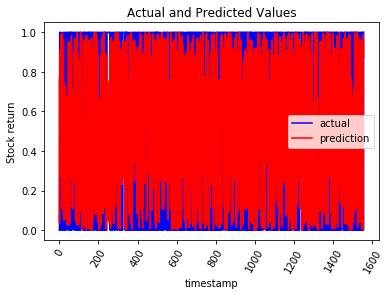

In [90]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [158]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=42).fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [159]:
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.938978829389788
0.0
0.4842646114322415


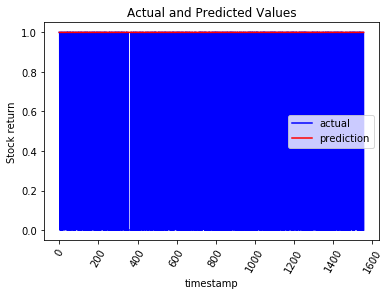

In [160]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

### Legacy

In [0]:
combined_data_day_2 = generate_day_n_dataset(2)

In [0]:
combined_data_day_2.shape

(15306, 4)

In [0]:
combined_data_day_2.dropna(axis=0,inplace=True)

In [0]:
returns = combined_data_day_2['return'].values
sentiments = combined_data_day_2['sentiment'].values.reshape(-1,1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.42281153158026274
-0.4227383821480952
0.0003796767918317302


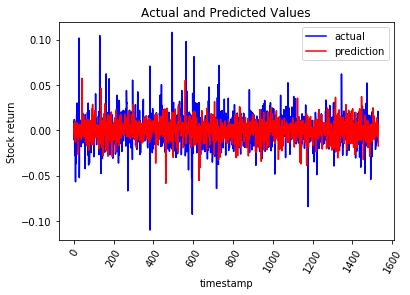

In [0]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(1531), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(1531),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_test, y_test)

-0.0002934152632418918

In [0]:
combined_data_day_3 = generate_day_n_dataset(3)

In [0]:
combined_data_day_3.shape

(15256, 4)

In [0]:
combined_data_day_3.dropna(axis=0,inplace=True)

In [0]:
returns = combined_data_day_3['return'].values
sentiments = combined_data_day_3['sentiment'].values.reshape(-1,1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.4395178761209624
-0.43925260854534587
0.0003378585134213496


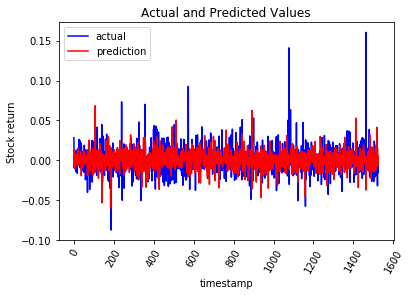

In [0]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(1526), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(1526),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_test, y_test)

-0.0006436370997764396

## Section 2: Stock return v sentiment z-score of Tweets

### Preprocessing

In [0]:
combined_data = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets.csv')

In [0]:
combined_data.head()

,timestamp,asset,Open,Close,Volume,return,sentiment
0,2014-01-03,VZ,49.330002,48.419998,12022200.0,-0.011837,0.858437
1,2014-01-09,VZ,48.430000,47.500000,14567000.0,-0.020619,0.121953
2,2014-01-10,VZ,47.840000,47.750000,11445900.0,0.005263,0.493868
3,2014-01-13,VZ,47.650002,47.029999,18784000.0,-0.015079,0.566625
4,2014-01-14,VZ,47.040001,47.080002,19270700.0,0.001063,0.028749


In [0]:
combined_data_by_stock = combined_data.groupby(combined_data.asset)

In [0]:
from scipy import stats

In [99]:
#dfObj = pd.DataFrame(columns=['timestemp', 'asset', 'Open','Close','Volume','return','sentiment','sentiment_zscore'])
data = []
for stock, df in combined_data_by_stock:
  df.loc[:,'sentiment_zscore'] = stats.zscore(df['sentiment'])
  data.append(df.values.tolist())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item)    

In [0]:
flat_list[0]

['2014-01-02',
 'AAPL',
 79.382858,
 79.01857,
 58671200.0,
 -0.14795587983514946,
 0.5655639938,
 -1.1380818498155505]

In [0]:
z_score_df = pd.DataFrame(np.asarray(flat_list), columns=['timestamp', 'asset', 'Open','Close','Volume','return','sentiment','sentiment_zscore'])

In [114]:
z_score_df.head()

,timestamp,asset,Open,Close,Volume,return,sentiment,sentiment_zscore
0,2014-01-02,AAPL,79.382858,79.01857,58671200.0,nan,0.5655639938,-1.1380818498155505
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021965849293400286,0.6017606199999999,-0.5444055848367247
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453020242780937,0.691131798,0.9214091255905716
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007151600455496232,0.6690509193103449,0.559251240612743
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.00633285838396902,0.6917643979999999,0.9317846673095822


In [0]:
z_score_df.to_csv(f'{DATA_DIR}/analysis/combined_price_tweets_zscore.csv',index=False)

### Day-1 Test

#### Percentage

In [0]:
combined_data_z_score = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets_zscore.csv')

In [7]:
combined_data_z_score.head()

,timestamp,asset,Open,Close,Volume,return,sentiment,sentiment_zscore
0,2014-01-02,AAPL,79.382858,79.018570,58671200.0,NaN,0.565564,-1.138082
1,2014-01-03,AAPL,78.980003,77.282860,98116900.0,-0.021966,0.601761,-0.544406
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453,0.691132,0.921409
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007152,0.669051,0.559251
4,2014-01-08,AAPL,76.972855,77.637146,64632400.0,0.006333,0.691764,0.931785


In [0]:
def generate_day_n_dataset_with_z_score(n):
  temp = []
  for stock, df in combined_data_z_score.groupby(combined_data_z_score.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      #sentiment = row['sentiment']
      sentiment_zscore = row['sentiment_zscore']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment_zscore])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment_zscore'])

In [20]:
combined_data_day_1 = generate_day_n_dataset_with_z_score(1)
combined_data_day_1.head()

,timestamp,return,asset,sentiment_zscore
0,2014-01-02,-0.021966,AAPL,-1.138082
1,2014-01-03,0.005453,AAPL,-0.544406
2,2014-01-06,-0.007152,AAPL,0.921409
3,2014-01-07,0.006333,AAPL,0.559251
4,2014-01-08,-0.012770,AAPL,0.931785


In [122]:
combined_data_day_1.tail()

,timestamp,return,asset,sentiment,sentiment_zscore
15564,2016-03-23,0.002746,XOM,0.417376,-0.869828
15565,2016-03-24,0.002858,XOM,0.540336,-0.164592
15566,2016-03-28,0.003681,XOM,0.595223,0.150214
15567,2016-03-29,-0.000118,XOM,0.428560,-0.805684
15568,2016-03-30,-0.011003,XOM,0.662568,0.536475


In [0]:
returns = combined_data_day_1['return'].values
sentiments = combined_data_day_1[['sentiment_zscore']].values.reshape(-1,1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [23]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [24]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.5437618858352002
-0.5436336693917916
0.0003273144088498452


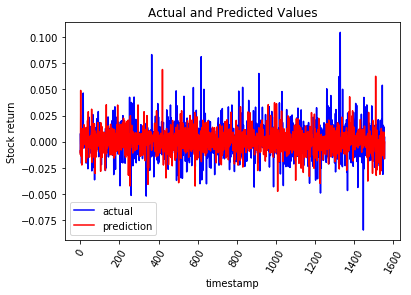

In [25]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

In [27]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.0018324571688677072
-0.0017893724785997822
0.0002124124202661014


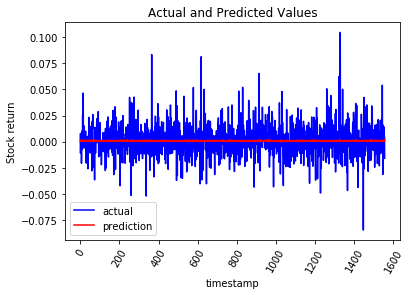

In [28]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

#### Directionality

In [0]:
combined_data_day_1['direction'] = combined_data_day_1['return'].apply(lambda x: 0 if x<0 else 1) #0=down 1=up

In [133]:
combined_data_day_1.head()

,timestamp,return,asset,sentiment,sentiment_zscore,direction
0,2014-01-02,-0.021966,AAPL,0.565564,-1.138082,0
1,2014-01-03,0.005453,AAPL,0.601761,-0.544406,1
2,2014-01-06,-0.007152,AAPL,0.691132,0.921409,0
3,2014-01-07,0.006333,AAPL,0.669051,0.559251,1
4,2014-01-08,-0.012770,AAPL,0.691764,0.931785,0


In [0]:
directions = combined_data_day_1['direction'].values
sentiments = combined_data_day_1['sentiment_zscore'].values.reshape(-1, 1)
#sentiments = combined_data_day_1[['sentiment','sentiment_zscore']].values

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, directions, test_size=.1)

In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [33]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.47228955328109845
-0.46876943365511425
0.36584945336705943


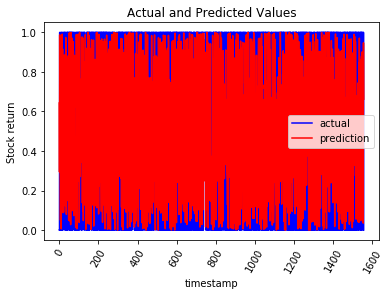

In [34]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [35]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=42).fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.8531960385257682
0.00020252256798591883
0.4605009633911368


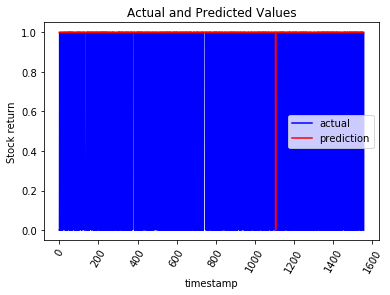

In [37]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

## Section 3: Stock return v sentiment change Tweets

### Preprocessing

In [0]:
combined_data = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets.csv')
combined_data_by_stock = combined_data.groupby(combined_data.asset)

In [46]:
data = []
for stock, df in combined_data_by_stock:
  df.loc[:,'sentiment_pct_change'] = df['sentiment'].pct_change()
  data.append(df.values.tolist())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item)

In [0]:
pct_df = pd.DataFrame(np.asarray(flat_list), columns=['timestamp', 'asset', 'Open','Close','Volume','return','sentiment','sentiment_pct_change'])

In [50]:
pct_df.head()

,timestamp,asset,Open,Close,Volume,return,sentiment,sentiment_pct_change
0,2014-01-02,AAPL,79.382858,79.01857,58671200.0,nan,0.5655639938,nan
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021965849293400286,0.6017606199999999,0.06400093817287811
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453020242780937,0.691131798,0.14851616245675925
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007151600455496231,0.6690509193103449,-0.031948868151563725
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.00633285838396902,0.6917643979999999,0.03394880424507596


In [0]:
pct_df.to_csv(f'{DATA_DIR}/analysis/combined_price_tweets_pct')

In [0]:
def generate_day_n_dataset_with_pct_change(n):
  temp = []
  for stock, df in pct_df.groupby(pct_df.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      #sentiment = row['sentiment']
      sentiment_pct_change = row['sentiment_pct_change']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment_pct_change])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment_pct_change'])

### Percentage change

In [53]:
combined_data_day_1 = generate_day_n_dataset_with_pct_change(1)
combined_data_day_1.head()

,timestamp,return,asset,sentiment_pct_change
0,2014-01-02,-0.021966,AAPL,nan
1,2014-01-03,0.005453,AAPL,0.06400093817287811
2,2014-01-06,-0.007152,AAPL,0.14851616245675925
3,2014-01-07,0.006333,AAPL,-0.031948868151563725
4,2014-01-08,-0.012770,AAPL,0.03394880424507596


In [57]:
combined_data_day_1['sentiment_pct_change'] = combined_data_day_1['sentiment_pct_change'].apply(lambda x: float(x))
combined_data_day_1.dropna(axis=0,inplace=True)
combined_data_day_1.head()

,timestamp,return,asset,sentiment_pct_change
1,2014-01-03,0.005453,AAPL,0.064001
2,2014-01-06,-0.007152,AAPL,0.148516
3,2014-01-07,0.006333,AAPL,-0.031949
4,2014-01-08,-0.012770,AAPL,0.033949
5,2014-01-09,-0.006673,AAPL,-0.259637


In [0]:
returns = combined_data_day_1['return'].values
sentiments = combined_data_day_1[['sentiment_pct_change']].values.reshape(-1,1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [61]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [62]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.5234344316470911
-0.5226433674048678
0.00034168049258742026


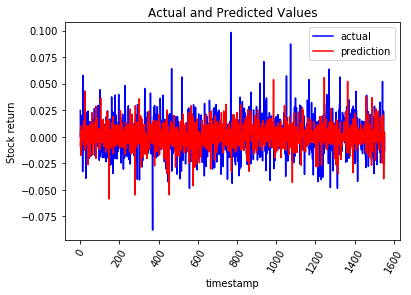

In [63]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

In [65]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.0012096275511892518
-7.769190365114476e-05
0.00022455433041190784


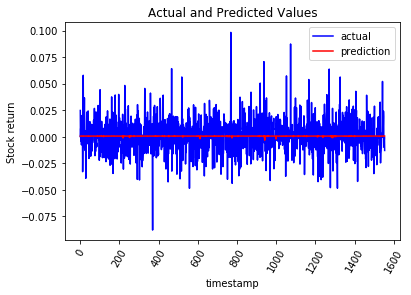

In [66]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

### Direcionality

In [0]:
combined_data_day_1['direction'] = combined_data_day_1['return'].apply(lambda x: 0 if x<0 else 1) #0=down 1=up

In [0]:
directions = combined_data_day_1['direction'].values
sentiments = combined_data_day_1['sentiment_pct_change'].values.reshape(-1, 1)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, directions, test_size=.1)

In [75]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [76]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.39475067869527347
-0.39474517010718957
0.34829724141097274


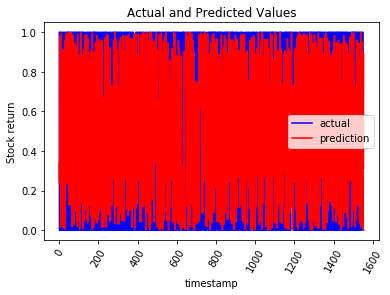

In [77]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [78]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=42).fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
predictions = reg.predict(x_test)
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.9352428393524286
-0.004974687133634914
0.48326898326898327


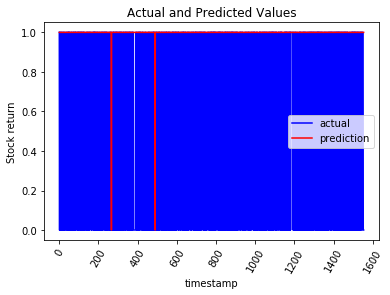

In [80]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

## Final Section: Stock return v sentiment of Tweets + News

### Preprocessing

#### Tweets

In [0]:
from scipy import stats
combined_data = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets.csv')
combined_data_by_stock = combined_data.groupby(combined_data.asset)
def generate_additional_sentiment_features():
  data = []
  for stock, df in combined_data_by_stock:
    df.loc[:,'sentiment_zscore'] = stats.zscore(df['sentiment'])
    df.loc[:,'sentiment_pct_change'] = df['sentiment'].pct_change()
    data.append(df.values.tolist())
  flat_list = []
  for sublist in data:
      for item in sublist:
          flat_list.append(item)
  return pd.DataFrame(np.asarray(flat_list), columns=['timestamp', 'asset', 'Open','Close','Volume','return','sentiment','sentiment_zscore','sentiment_pct_change'])

In [96]:
add_df = generate_additional_sentiment_features()
def generate_day_n_dataset_with_all_features(n):
  temp = []
  for stock, df in add_df.groupby(add_df.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      sentiment = row['sentiment']
      sentiment_zscore = row['sentiment_zscore']
      sentiment_pct_change = row['sentiment_pct_change']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment,sentiment_zscore,sentiment_pct_change])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment','sentiment_zscore','sentiment_pct_change'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [99]:
add_df['return'] = add_df['return'].apply(lambda x: float(x))
add_df['sentiment_zscore'] = add_df['sentiment_zscore'].apply(lambda x: float(x))
add_df['sentiment_pct_change'] = add_df['sentiment_pct_change'].apply(lambda x: float(x))
add_df.head()

,timestamp,asset,Open,Close,Volume,return,sentiment,sentiment_zscore,sentiment_pct_change
0,2014-01-02,AAPL,79.382858,79.01857,58671200.0,NaN,0.5655639938,-1.138082,NaN
1,2014-01-03,AAPL,78.980003,77.28286,98116900.0,-0.021966,0.6017606199999999,-0.544406,0.064001
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453,0.691131798,0.921409,0.148516
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007152,0.6690509193103449,0.559251,-0.031949
4,2014-01-08,AAPL,76.97285500000002,77.637146,64632400.0,0.006333,0.6917643979999999,0.931785,0.033949


In [0]:
add_df.to_csv(f'{DATA_DIR}/analysis/combined_price_tweets_all.csv',index=False)

In [0]:
combined_all_df_day_1 = generate_day_n_dataset_with_all_features(1)
combined_all_df_day_1['return'] = combined_all_df_day_1['return'].apply(lambda x: float(x))
combined_all_df_day_1['sentiment_zscore'] = combined_all_df_day_1['sentiment_zscore'].apply(lambda x: float(x))
combined_all_df_day_1['sentiment_pct_change'] = combined_all_df_day_1['sentiment_pct_change'].apply(lambda x: float(x))

In [102]:
combined_all_df_day_1.head()

,timestamp,return,asset,sentiment,sentiment_zscore,sentiment_pct_change
0,2014-01-02,-0.021966,AAPL,0.5655639938,-1.138082,NaN
1,2014-01-03,0.005453,AAPL,0.6017606199999999,-0.544406,0.064001
2,2014-01-06,-0.007152,AAPL,0.691131798,0.921409,0.148516
3,2014-01-07,0.006333,AAPL,0.6690509193103449,0.559251,-0.031949
4,2014-01-08,-0.012770,AAPL,0.6917643979999999,0.931785,0.033949


#### News

In [0]:
indexed_news = pd.read_csv(f'{DATA_DIR}/indexed/news/indexed_news_title_only_.csv')

In [139]:
indexed_news.head()

,timestamp,title,sentiment
0,2014-01-01,the daily dot the nsa leaks you need to unders...,0.824581
1,2014-01-01,hadron collider upgrade will lead to highest e...,0.818177
2,2014-01-01,egypt says journalists will be held more days,0.260239
3,2014-01-01,latvia becomes th eurozone member,0.783358
4,2014-01-01,most australians want google to stop giving da...,0.457299


In [145]:
indexed_news.timestamp.unique().shape

(915,)

In [0]:
import datetime
news_days = indexed_news.timestamp.unique()
all_stock_price = pd.read_csv(f'{DATA_DIR}/preprocessed/price/all_stock_price.csv')
work_days = all_stock_price.timestamp.unique()
end = work_days[-1]
next_work_day_map = dict()
list_of_days = news_days
for date in list_of_days:
    next_work_day = pd.to_datetime(date)
    decay = 0
    while next_work_day.strftime('%Y-%m-%d') not in work_days:
      if(next_work_day.strftime('%Y-%m-%d') > end): break
      next_work_day += datetime.timedelta(days=1)
      decay += 1
    next_work_day_map[date] = (next_work_day.strftime('%Y-%m-%d'),decay)

In [0]:
indexed_news_by_day = indexed_news.groupby(indexed_news.timestamp)
temp = []
for group_name,group_values in indexed_news_by_day:
    avg_sen = group_values['sentiment'].mean()
    next_work_day = next_work_day_map[group_name][0]
    decay = next_work_day_map[group_name][1]
    temp.append([group_name,avg_sen,next_work_day,decay])
average_news = pd.DataFrame(np.array(temp),columns=['timestamp','sentiment','next_work_day','decay'])

In [151]:
indexed_news_by_day.get_group('2014-01-01').sentiment.values.mean()

0.3409652158

In [0]:
average_news.to_csv(f'{DATA_DIR}/analysis/average_news_title_only.csv',index=False)

In [144]:
average_news.head()

,timestamp,sentiment,next_work_day,decay
0,2014-01-01,0.34096521579999994,2014-01-02,1
1,2014-01-02,0.34549740336,2014-01-02,0
2,2014-01-03,0.28599565139999994,2014-01-03,0
3,2014-01-04,0.26057405016,2014-01-06,2
4,2014-01-05,0.25320122580000004,2014-01-06,1


In [0]:
temp = []
decayed_sen = []
for i,row in average_news.iterrows():
    decayed_sen.append(float(row['sentiment']))
    if int(row['decay']) == 0:
        sentiment = 0
        total_weight = 0
        for i in range(len(decayed_sen)):
          weight = pow((1/2),i)
          total_weight += weight
          sentiment += weight*decayed_sen[i]
        sentiment /= total_weight
        temp.append([row['timestamp'],sentiment])
decayed_news = pd.DataFrame(temp, columns=['timestamp','sentiment'])

In [148]:
decayed_news.describe()

,sentiment
count,633.000000
mean,0.323759
std,0.000861
min,0.323707
25%,0.323707
50%,0.323707
75%,0.323707
max,0.342476


In [0]:
decayed_news.to_csv(f'{DATA_DIR}/analysis/decayed_news_title_only.csv',index=False)

In [0]:
decayed_news.loc[:,'sentiment_zscore'] = stats.zscore(decayed_news['sentiment'])
decayed_news.loc[:,'sentiment_pct_change'] = decayed_news['sentiment'].pct_change()

In [154]:
decayed_news.head()

,timestamp,sentiment,sentiment_zscore,sentiment_pct_change
0,2014-01-02,0.342476,21.757175,NaN
1,2014-01-03,0.334407,12.378117,-0.023560
2,2014-01-06,0.325380,1.884647,-0.026995
3,2014-01-07,0.324345,0.681717,-0.003180
4,2014-01-08,0.324086,0.379914,-0.000800


In [0]:
decayed_news.to_csv(f'{DATA_DIR}/analysis/news_title_only_all_features.csv',index=False)

### Analysis: Tweets + News

In [0]:
price_tweets = pd.read_csv(f'{DATA_DIR}/analysis/combined_price_tweets_all.csv')
news = pd.read_csv(f'{DATA_DIR}/analysis/news_title_only_all_features.csv')

In [157]:
price_tweets.head()

,timestamp,asset,Open,Close,Volume,return,sentiment,sentiment_zscore,sentiment_pct_change
0,2014-01-02,AAPL,79.382858,79.018570,58671200.0,NaN,0.565564,-1.138082,NaN
1,2014-01-03,AAPL,78.980003,77.282860,98116900.0,-0.021966,0.601761,-0.544406,0.064001
2,2014-01-06,AAPL,76.778572,77.704285,103152700.0,0.005453,0.691132,0.921409,0.148516
3,2014-01-07,AAPL,77.760002,77.148575,79302300.0,-0.007152,0.669051,0.559251,-0.031949
4,2014-01-08,AAPL,76.972855,77.637146,64632400.0,0.006333,0.691764,0.931785,0.033949


In [158]:
news.head()

,timestamp,sentiment,sentiment_zscore,sentiment_pct_change
0,2014-01-02,0.342476,21.757175,NaN
1,2014-01-03,0.334407,12.378117,-0.023560
2,2014-01-06,0.325380,1.884647,-0.026995
3,2014-01-07,0.324345,0.681717,-0.003180
4,2014-01-08,0.324086,0.379914,-0.000800


In [159]:
price_tweets_news = price_tweets.merge(news, on='timestamp',suffixes=('_tweets','_news'))
price_tweets_news.head() 

,timestamp,asset,Open,Close,Volume,return,sentiment_tweets,sentiment_zscore_tweets,sentiment_pct_change_tweets,sentiment_news,sentiment_zscore_news,sentiment_pct_change_news
0,2014-01-02,AAPL,79.382858,79.018570,58671200.0,NaN,0.565564,-1.138082,NaN,0.342476,21.757175,NaN
1,2014-01-02,AEP,46.980000,46.130001,2752000.0,NaN,0.429838,-0.676142,NaN,0.342476,21.757175,NaN
2,2014-01-02,AMGN,114.360001,115.800003,2528800.0,NaN,0.805012,1.216801,NaN,0.342476,21.757175,NaN
3,2014-01-02,AMZN,398.799988,397.970001,2137800.0,NaN,0.178008,-4.286250,NaN,0.342476,21.757175,NaN
4,2014-01-02,BA,136.009995,136.669998,3366700.0,NaN,0.806881,1.420988,NaN,0.342476,21.757175,NaN


In [0]:
price_tweets_news.to_csv(f'{DATA_DIR}/analysis/combined_price_tweets_news.csv', index=False)

In [0]:
def generate_day_n_dataset_with_all_features(n):
  temp = []
  for stock, df in price_tweets_news.groupby(price_tweets_news.asset):
    all_dates = set(df['timestamp'].values)
    for i,row in df.iterrows():
      date = row['timestamp']
      next_n_day = next_n_working_day(date,n)
      sentiment_t = row['sentiment_tweets']
      sentiment_zscore_t = row['sentiment_zscore_tweets']
      sentiment_pct_change_t = row['sentiment_pct_change_tweets']
      sentiment_n = row['sentiment_news']
      sentiment_zscore_n = row['sentiment_zscore_news']
      sentiment_pct_change_n = row['sentiment_pct_change_news']
      if next_n_day in all_dates:
        temp.append([row['timestamp'],stock_return_map[(str(next_n_day),stock)],stock,sentiment_t,sentiment_zscore_t,sentiment_pct_change_t,sentiment_n,sentiment_zscore_n,sentiment_pct_change_n])
  return pd.DataFrame(temp, columns=['timestamp','return','asset','sentiment_tweets','sentiment_zscore_tweets','sentiment_pct_change_tweets','sentiment_news','sentiment_zscore_news','sentiment_pct_change_news'])

In [0]:
price_tweets_news_day_1 = generate_day_n_dataset_with_all_features(1)

In [190]:
price_tweets_news_day_1.head()

,timestamp,return,asset,sentiment_tweets,sentiment_zscore_tweets,sentiment_pct_change_tweets,sentiment_news,sentiment_zscore_news,sentiment_pct_change_news
0,2014-01-02,-0.021966,AAPL,0.565564,-1.138082,NaN,0.342476,21.757175,NaN
1,2014-01-03,0.005453,AAPL,0.601761,-0.544406,0.064001,0.334407,12.378117,-0.023560
2,2014-01-06,-0.007152,AAPL,0.691132,0.921409,0.148516,0.325380,1.884647,-0.026995
3,2014-01-07,0.006333,AAPL,0.669051,0.559251,-0.031949,0.324345,0.681717,-0.003180
4,2014-01-08,-0.012770,AAPL,0.691764,0.931785,0.033949,0.324086,0.379914,-0.000800


In [0]:
price_tweets_news_day_1.dropna(axis=0,inplace=True)

In [192]:
price_tweets_news_day_1.head()

,timestamp,return,asset,sentiment_tweets,sentiment_zscore_tweets,sentiment_pct_change_tweets,sentiment_news,sentiment_zscore_news,sentiment_pct_change_news
1,2014-01-03,0.005453,AAPL,0.601761,-0.544406,0.064001,0.334407,12.378117,-0.023560
2,2014-01-06,-0.007152,AAPL,0.691132,0.921409,0.148516,0.325380,1.884647,-0.026995
3,2014-01-07,0.006333,AAPL,0.669051,0.559251,-0.031949,0.324345,0.681717,-0.003180
4,2014-01-08,-0.012770,AAPL,0.691764,0.931785,0.033949,0.324086,0.379914,-0.000800
5,2014-01-09,-0.006673,AAPL,0.512157,-2.014032,-0.259637,0.323897,0.161304,-0.000580


#### Percentage change

In [193]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Conv1D,MaxPooling1D,Bidirectional,Dropout,Flatten

dense_model = Sequential()
dense_model.add(Dense(128,activation='relu',input_dim=6))
dense_model.add(Dense(256,activation='relu'))
dense_model.add(Dense(1,activation='relu'))
dense_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['acc'])
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 34,177
Trainable params: 34,177
Non-trainable params: 0
_________________________________________________________________


In [0]:
returns = price_tweets_news_day_1['return'].values
sentiments = price_tweets_news_day_1[['sentiment_tweets','sentiment_zscore_tweets','sentiment_pct_change_tweets','sentiment_news','sentiment_zscore_news','sentiment_pct_change_news']].values

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, returns, test_size=.1)

In [196]:
history = dense_model.fit(x_train,
          y_train,
          batch_size=8,
          shuffle=True,
          epochs=15,
          validation_data=(x_test,y_test))

Train on 13979 samples, validate on 1554 samples
Epoch 1/15
13979/13979 [==============================] - 7s 501us/sample - loss: 2.4511e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 2/15
13979/13979 [==============================] - 6s 450us/sample - loss: 2.4491e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 3/15
13979/13979 [==============================] - 6s 447us/sample - loss: 2.4491e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 4/15
13979/13979 [==============================] - 6s 447us/sample - loss: 2.4491e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 5/15
13979/13979 [==============================] - 6s 450us/sample - loss: 2.4491e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 6/15
13979/13979 [==============================] - 6s 445us/sample - loss: 2.4491e-04 - acc: 0.0078 - val_loss: 2.4456e-04 - val_acc: 0.0032
Epoch 7/15
13979/13979 [==============================] - 6s 45

In [197]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [198]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.10297503745889292
-0.10214733227150341
0.0002695505441301346


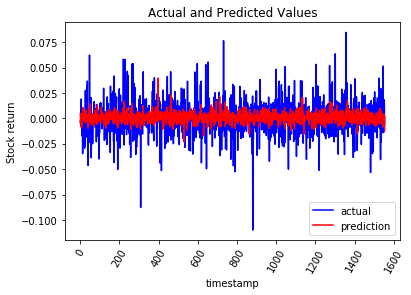

In [199]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

In [201]:
# Use the forest's predict method on the test data
predictions = reg.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.0012658242302274747
-0.0008303525544228751
0.00024469433901419925


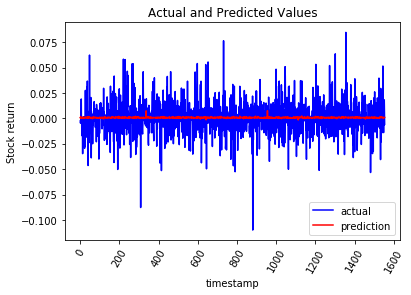

In [202]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

#### Direconality

In [0]:
price_tweets_news_day_1['direction'] = price_tweets_news_day_1['return'].apply(lambda x: 0 if x<0 else 1) #0=down 1=up

In [0]:
directions = price_tweets_news_day_1['direction'].values
sentiments = price_tweets_news_day_1[['sentiment_tweets','sentiment_zscore_tweets','sentiment_pct_change_tweets','sentiment_news','sentiment_zscore_news','sentiment_pct_change_news']].values

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentiments, directions, test_size=.1)

In [213]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [214]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.12103106627652549
-0.1206523142456899
0.28001219884169887


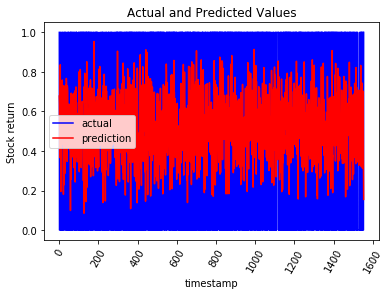

In [215]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');

In [216]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression().fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [217]:
# Use the forest's predict method on the test data
predictions = reg.predict(x_test)
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error
print(r2_score(y_test,predictions))
print(explained_variance_score(y_test,predictions))
print(mean_squared_error(y_test,predictions))

-0.9425000000000006
-0.019893899204244114
0.4851994851994852


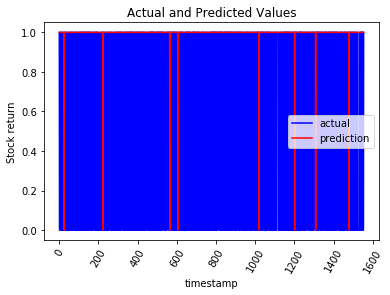

In [218]:
import matplotlib.pyplot as plt
# Plot the actual values
plt.plot(range(predictions.shape[0]), y_test, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(range(predictions.shape[0]),predictions, 'r-', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('timestamp'); plt.ylabel('Stock return'); plt.title('Actual and Predicted Values');